## Validation example with original DFN [1] model

[1] T. F. Fuller, M. Doyle, and J. Newman, “Simulation and Optimization of the Dual Lithium Ion Insertion Cell,” J. Electrochem. Soc., vol. 141, no. 1, pp. 1–10, 1994, doi: 10.1149/1.2054684.

In [1]:
import os
import numpy as np
from cideMOD import (
    CellParser,
    ErrorCheck,
    NDProblem,
    Problem,
    SolverCrashed,
    Trigger,
    init_results_folder,
    ModelOptions,
)

In [2]:
overwrite = True
case = "dfn_94"
data_path = f"../../data/data_{case}"
params = "params.json"

model_options = ModelOptions(mode='P2D', clean_on_exit=False)

In [3]:
reference = dict()
current_list = [30, 40, 50]
for I in current_list:
    reference[f'{I}A/m^2']= np.genfromtxt(os.path.join(data_path, "data_reference", f"V_{I}A_m2.txt"))

In [ ]:
cell = CellParser(params, data_path=data_path)
results = dict()
for I in current_list:
    save_path = init_results_folder(
        case, overwrite=overwrite, copy_files=[f"{data_path}/{params}"]
    )
    problem = Problem(cell, model_options, save_path=save_path)
    problem.set_cell_state(1, 273 + 25, 273 + 25)
    problem.setup()
    problem.global_storage_order['cathode_SOC']= {
                'fnc': problem.get_soc_c,
                'header': 'Cathode SOC [-]'
            }
    problem.WH.global_variables(problem.global_storage_order)
    I_app = -cell.area*I
    t_f = 3600*2
    v_min = Trigger(2.0, "v")
    status = problem.solve_ie(
        min_step=10, i_app=I_app, t_f=t_f, store_delay=10, adaptive=True, triggers=[v_min]
    )
    err = ErrorCheck(problem, status)
    results[f'{I}A/m^2']= {key: problem.WH.get_global_variable(key) for key in ['time', *problem.WH.global_vars.keys()]}

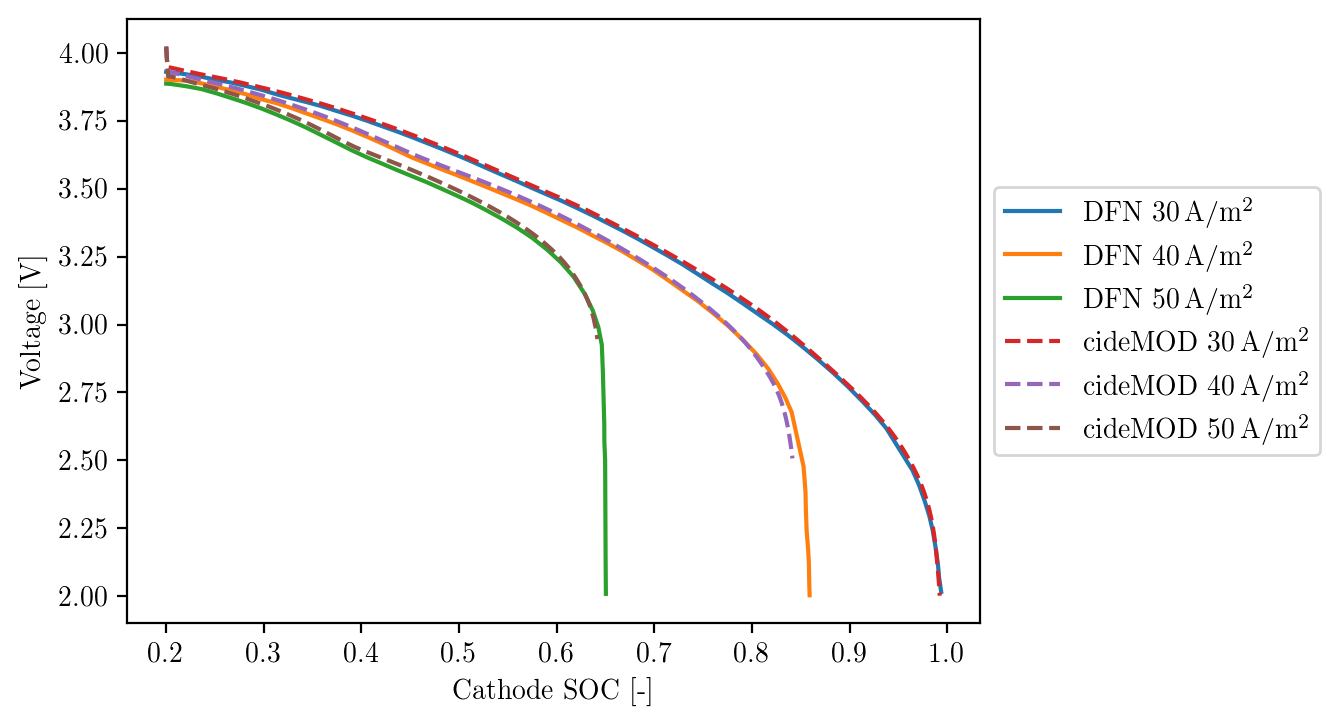

In [5]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
for I in current_list:
    tag = f'{I}A/m^2'
    ax1.plot(reference[tag][:,0], reference[tag][:,1], "-", label=f'DFN ${I}\,\mathrm{{A/m^2}}$')
for I in current_list:
    tag = f'{I}A/m^2'
    ax1.plot(results[tag]['cathode_SOC'], results[tag]['voltage'], "--", label=f'cideMOD ${I}\,\mathrm{{A/m^2}}$')
ax1.set_xlabel("Cathode SOC [-]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()